In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

# Electronic Energy Minimisation

A central problem of electronic structure simulations is finding the ground state 
configuration of many interacting electrons.  Within MESS this is handled by:

* building a `Hamiltonian` by selecting how to model the quantum-mechanical interactions
  with the `xc_method` argument.
* minimisation of the total energy subject to the constraint of orthonormal orbitals.

On the second point, there are many possible approaches to solving this constrained 
optimisation problem.  In the following we setup minimising the total energy with the 
[Adam optimiser](https://optax.readthedocs.io/en/latest/api/optimizers.html#adam) 
from the [optax library](https://optax.readthedocs.io/en/latest/index.html).


:::{note}
The following code cell will install MESS into the Google Colab runtime.
Select the 🚀 in the toolbar above to try this out!
:::

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install git+https://github.com/graphcore-research/mess.git

In [3]:
import jax
import jax.numpy as jnp
import optax
import seaborn as sns
from tqdm.notebook import tqdm

from mess import Hamiltonian, basisset, molecule
from mess.structure import nuclear_energy

sns.set_theme(style="whitegrid")

/home/ubuntu/miniforge3/envs/jax/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
mol = molecule("water")
basis = basisset(mol, "6-31g")
H = Hamiltonian(basis, xc_method="pbe")
optimiser = optax.adam(learning_rate=0.1)

Next we define a function that evaluates the total energy given an arbitrary matrix $Z$
which applies the orthonormal constraint.  This efffectively converts the minimisation 
problem into an unconstrained optimisation one.

In [5]:
E_n = nuclear_energy(mol)


@jax.jit
@jax.value_and_grad
def total_energy(Z):
    C = H.orthonormalise(Z)
    P = basis.density_matrix(C)
    return H(P) + E_n

We use a somewhat arbitrary initial guess and use the Adam optimiser to minimise
the total energy.  The function transformation
[jax.value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html)
uses automatic differentiation to evaluate both the energy and the gradient of the
energy with respect to the trial matrix $Z$.

In [6]:
Z = jnp.eye(basis.num_orbitals)
state = optimiser.init(Z)
history = []

for _ in (bar := tqdm(range(128))):
    e, grads = total_energy(Z)
    updates, state = optimiser.update(grads, state)
    Z = optax.apply_updates(Z, updates)
    history.append(e)
    bar.set_description(f"Total energy: {e:0.06f} (Hartree)")

  0%|          | 0/128 [00:00<?, ?it/s]

Next we can look at how the variation in the total energy through the optimisation process.

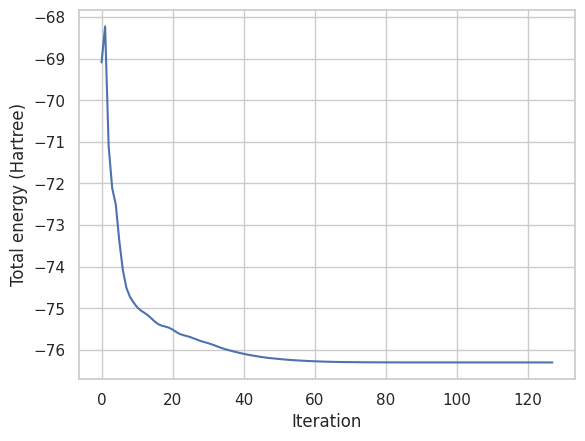

In [7]:
history = jnp.stack(history)
ax = sns.lineplot(history)
ax.set_xlabel("Iteration")
ax.set_ylabel("Total energy (Hartree)");